# POMDP Setup

In [110]:
import random
from collections import defaultdict
import numpy as np
from utils import vector_add, orientations, turn_right, turn_left

class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states #or self.get_states_from_transitions(transitions)

        self.init = init #is just the initial value which we can also just make randomly

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions #or {}
        # if not self.transitions:
        #     print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward #or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state): #Reward Function
        """Return a numeric reward for this state."""

        return self.reward[state]
    
    #this one needs to be extended 

    def T(self, state, action): #Transition Function
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

#this is just if the states were not passed but we'll make sure they are always passed

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001



class POMDP(MDP):
    """A Partially Observable Markov Decision Process, defined by
    a transition model P(s'|s,a), actions A(s), a reward function R(s),
    and a sensor model P(e|s). We also keep track of a gamma value,
    for use by algorithms. The transition and the sensor models
    are defined as matrices. We also keep track of the possible states
    and actions for each state. [Page 659]."""

    def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95):
        """Initialize variables of the pomdp"""

        if not (0 < gamma <= 1):
            raise ValueError('A POMDP must have 0 < gamma <= 1')

        self.states = states
        self.actions = actions

        # transition model cannot be undefined
        self.t_prob = transitions or {}
        if not self.t_prob:
            print('Warning: Transition model is undefined')

        # sensor model cannot be undefined
        self.e_prob = evidences or {}
        if not self.e_prob:
            print('Warning: Sensor model is undefined')

        self.gamma = gamma
        self.rewards = rewards

    def remove_dominated_plans(self, input_values):
        """
        Remove dominated plans.
        This method finds all the lines contributing to the
        upper surface and removes those which don't.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = [values[0]]
        y1_max = max(val[1] for val in values)
        tgt = values[0]
        prev_b = 0
        prev_ix = 0
        while tgt[1] != y1_max:
            min_b = 1
            min_ix = 0
            for i in range(prev_ix + 1, len(values)):
                if values[i][0] - tgt[0] + tgt[1] - values[i][1] != 0:
                    trans_b = (values[i][0] - tgt[0]) / (values[i][0] - tgt[0] + tgt[1] - values[i][1])
                    if 0 <= trans_b <= 1 and trans_b > prev_b and trans_b < min_b:
                        min_b = trans_b
                        min_ix = i
            prev_b = min_b
            prev_ix = min_ix
            tgt = values[min_ix]
            best.append(tgt)

        return self.generate_mapping(best, input_values)

    def remove_dominated_plans_fast(self, input_values):
        """
        Remove dominated plans using approximations.
        Resamples the upper boundary at intervals of 100 and
        finds the maximum values at these points.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = []
        sr = 100
        for i in range(sr + 1):
            x = i / float(sr)
            maximum = (values[0][1] - values[0][0]) * x + values[0][0]
            tgt = values[0]
            for value in values:
                val = (value[1] - value[0]) * x + value[0]
                if val > maximum:
                    maximum = val
                    tgt = value

            if all(any(tgt != v) for v in best):
                best.append(np.array(tgt))

        return self.generate_mapping(best, input_values)

    def generate_mapping(self, best, input_values):
        """Generate mappings after removing dominated plans"""

        mapping = defaultdict(list)
        for value in best:
            for action in input_values:
                if any(all(value == v) for v in input_values[action]):
                    mapping[action].append(value)

        return mapping

    def max_difference(self, U1, U2):
        """Find maximum difference between two utility mappings"""

        for k, v in U1.items():
            sum1 = 0
            for element in U1[k]:
                sum1 += sum(element)
            sum2 = 0
            for element in U2[k]:
                sum2 += sum(element)
        return abs(sum1 - sum2)

#%%

class Matrix:
    """Matrix operations class"""

    @staticmethod
    def add(A, B):
        """Add two matrices A and B"""

        res = []
        for i in range(len(A)):
            row = []
            for j in range(len(A[0])):
                row.append(A[i][j] + B[i][j])
            res.append(row)
        return res

    @staticmethod
    def scalar_multiply(a, B):
        """Multiply scalar a to matrix B"""

        for i in range(len(B)):
            for j in range(len(B[0])):
                B[i][j] = a * B[i][j]
        return B

    @staticmethod
    def multiply(A, B):
        """Multiply two matrices A and B element-wise"""

        matrix = []
        for i in range(len(B)):
            row = []
            for j in range(len(B[0])):
                row.append(B[i][j] * A[j][i])
            matrix.append(row)

        return matrix

    @staticmethod
    def matmul(A, B):
        """Inner-product of two matrices"""

        return [[sum(ele_a * ele_b for ele_a, ele_b in zip(row_a, col_b)) for col_b in list(zip(*B))] for row_a in A]

    @staticmethod
    def transpose(A):
        """Transpose a matrix"""

        return [list(i) for i in zip(*A)]
    
def pomdp_value_iteration(pomdp, epsilon=0.1):
    """Solving a POMDP by value iteration."""

    U = {'':[[0]* len(pomdp.states)]}
    count = 0
    while True:
        count += 1
        prev_U = U
        values = [val for action in U for val in U[action]]
        value_matxs = []
        for i in values:
            for j in values:
                value_matxs.append([i, j])

        U1 = defaultdict(list)
        for action in pomdp.actions:
            for u in value_matxs:
                u1 = Matrix.matmul(Matrix.matmul(pomdp.t_prob[int(action)], Matrix.multiply(pomdp.e_prob[int(action)], Matrix.transpose(u))), [[1], [1]])
                u1 = Matrix.add(Matrix.scalar_multiply(pomdp.gamma, Matrix.transpose(u1)), [pomdp.rewards[int(action)]])
                U1[action].append(u1[0])

        U = pomdp.remove_dominated_plans_fast(U1)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations
        
        if count > 10:
            if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
                return U

def pomdp_value_iteration_numpy(pomdp, epsilon=0.1):
    """Solving a POMDP by value iteration."""

    U = {'': np.zeros((1, len(pomdp.states)))}
    count = 0
    while True:
        count += 1
        print(count)
        prev_U = U
        values = [val for action in U for val in U[action]]
        value_matxs = []
        for i in values:
            for j in values:
                value_matxs.append(np.array([i, j]))

        if count < 10:
            # print(f"values: {values}")
            print(f"value_matxs: {value_matxs}")
        U1 = defaultdict(list)
        for action in pomdp.actions:
            for u in value_matxs:
                u1 = np.matmul(np.matmul(pomdp.t_prob[int(action)], np.multiply(pomdp.e_prob[int(action)], u.T)), np.array([[1], [1]]))
                u1 = np.add(np.multiply(pomdp.gamma, u1.T), [pomdp.rewards[int(action)]])
                U1[action].append(u1[0])

        U = pomdp.remove_dominated_plans_fast(U1)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations
        
        if count > 10:
            if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
                return U 
        if count == 200:
            print('fail')
            break

p_stay = 0.89
# # Initial Conditions

# transition probability P(s'|s,a)
t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[3.5, 4.0], [3.5, 4.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1') #stay and switch
# states
states = ('0', '1')

pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)

1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]])]
3
value_matxs: [array([[6.87725, 7.74775],
       [6.87725, 7.74775]]), array([[6.87725, 7.74775],
       [6.87725, 7.74775]]), array([[6.87725, 7.74775],
       [6.87725, 7.74775]]), array([[6.87725, 7.74775],
       [6.87725, 7.74775]])]
4
value_matxs: [array([[10.12435475, 11.26939525],
       [10.12435475, 11.26939525]]), array([[10.12435475, 11.26939525],
       [10.12435475, 11.26939525]]), array([[10.12435475, 11.26939525],
       [10.12435475, 11.26939525]]), array([[10.12435475, 11.26939525],
       [10.12435475, 11.26939525]])]
5
value_matxs: [array([[13.23779374, 14.58626876],
       [13.23779374, 14.58626876]]), array([[13.23779374, 14.58626876],
       [13.23779374, 14.58626876]]), array([[13.23779374, 14.58626876],
       [13.23779374, 14.58626876]

In [ ]:
print(len(utility['1']))
print((utility['1']))
print((utility['0']))

In [22]:
import matplotlib.pyplot as plt

In [62]:
def plot_pomdp_utility(utility):
    colors = ['g', 'b']
    for action in utility:
        for value in utility[action]:
            print(value)
            plt.plot(value, color=colors[int(action)])
    # plt.ylim(-40, 60)
    plt.xlim(0, 1)
    plt.show()

### Example Parameters from Notebook on github

1
values: [array([0., 0.])]
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
values: [array([1., 1.])]
value_matxs: [array([[1., 1.],
       [1., 1.]])]
3
values: [array([1.95, 1.95])]
value_matxs: [array([[1.95, 1.95],
       [1.95, 1.95]])]
4
values: [array([2.8525, 2.8525])]
value_matxs: [array([[2.8525, 2.8525],
       [2.8525, 2.8525]])]
5
values: [array([3.709875, 3.709875])]
value_matxs: [array([[3.709875, 3.709875],
       [3.709875, 3.709875]])]
6
values: [array([4.52438125, 4.52438125])]
value_matxs: [array([[4.52438125, 4.52438125],
       [4.52438125, 4.52438125]])]
7
values: [array([5.29816219, 5.29816219])]
value_matxs: [array([[5.29816219, 5.29816219],
       [5.29816219, 5.29816219]])]
8
values: [array([6.03325408, 6.03325408])]
value_matxs: [array([[6.03325408, 6.03325408],
       [6.03325408, 6.03325408]])]
9
values: [array([6.73159137, 6.73159137])]
value_matxs: [array([[6.73159137, 6.73159137],
       [6.73159137, 6.73159137]])]
10
11
12
13
14
15
16
17
18
19
20
2

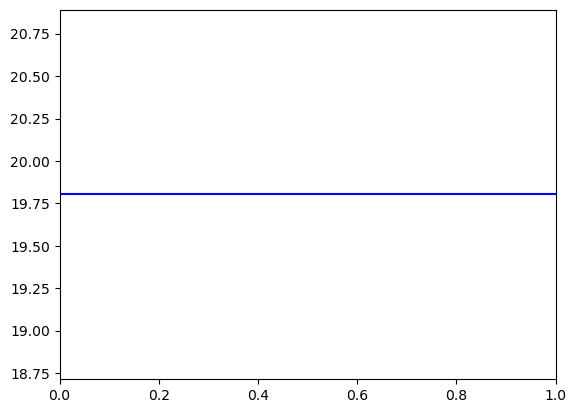

In [83]:
# transition probability P(s'|s,a)
t_prob = [[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[0, 0], [1.0, 1.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
plot_pomdp_utility(utility)

In [84]:
print(len(utility))

1


Other parameters from aima-python

1
values: [array([0., 0.])]
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
values: [array([  5., -10.]), array([-20.,   5.])]
value_matxs: [array([[  5., -10.],
       [  5., -10.]]), array([[  5., -10.],
       [-20.,   5.]]), array([[-20.,   5.],
       [  5., -10.]]), array([[-20.,   5.],
       [-20.,   5.]])]
3
values: [array([  4.7625, -10.2375]), array([-20.2375,   4.7625])]
value_matxs: [array([[  4.7625, -10.2375],
       [  4.7625, -10.2375]]), array([[  4.7625, -10.2375],
       [-20.2375,   4.7625]]), array([[-20.2375,   4.7625],
       [  4.7625, -10.2375]]), array([[-20.2375,   4.7625],
       [-20.2375,   4.7625]])]
4
values: [array([  4.536875, -10.463125]), array([-20.463125,   4.536875])]
value_matxs: [array([[  4.536875, -10.463125],
       [  4.536875, -10.463125]]), array([[  4.536875, -10.463125],
       [-20.463125,   4.536875]]), array([[-20.463125,   4.536875],
       [  4.536875, -10.463125]]), array([[-20.463125,   4.536875],
       [-20.463125,   4.5368

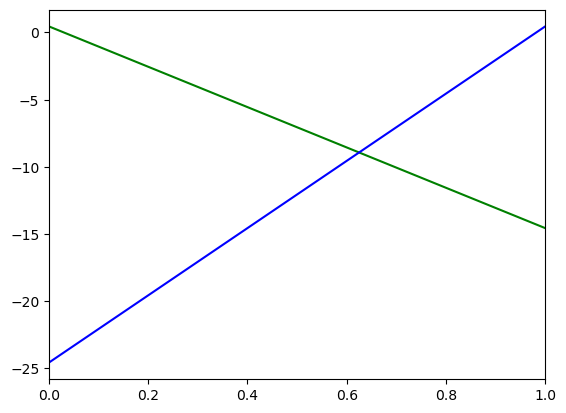

In [78]:
# transition probability P(s'|s,a)
t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]]]
# evidence function P(e|s)
e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]]]
# reward function
rewards = [[5, -10], [-20, 5]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
plot_pomdp_utility(utility)

In [82]:
print(len(utility))

2


Here the length of the utility is 2. So this can be a criteria: it needs to be at least two!

There seems to be some improvement with those parameters

1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[  5., -10.],
       [  5., -10.]]), array([[  5., -10.],
       [-20.,   5.]]), array([[-20.,   5.],
       [  5., -10.]]), array([[-20.,   5.],
       [-20.,   5.]])]
3
value_matxs: [array([[  4.7625, -10.2375],
       [  4.7625, -10.2375]]), array([[  4.7625, -10.2375],
       [-20.2375,   4.7625]]), array([[-20.2375,   4.7625],
       [  4.7625, -10.2375]]), array([[-20.2375,   4.7625],
       [-20.2375,   4.7625]])]
4
value_matxs: [array([[  4.536875, -10.463125],
       [  4.536875, -10.463125]]), array([[  4.536875, -10.463125],
       [-20.463125,   4.536875]]), array([[-20.463125,   4.536875],
       [  4.536875, -10.463125]]), array([[-20.463125,   4.536875],
       [-20.463125,   4.536875]])]
5
value_matxs: [array([[  4.32253125, -10.67746875],
       [  4.32253125, -10.67746875]]), array([[  4.32253125, -10.67746875],
       [-20.67746875,   4.32253125]]), array([[-20.67746875,   4.32253125],
       

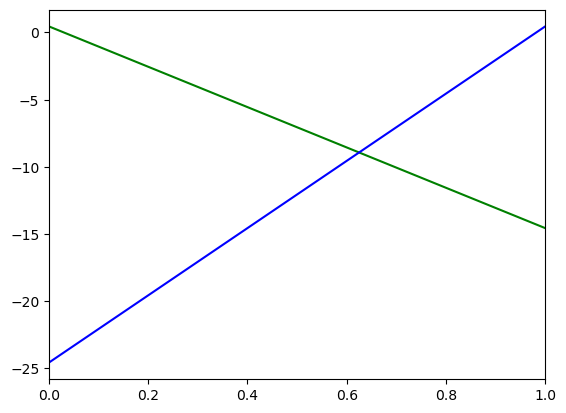

In [113]:
# transition probability P(s'|s,a)
t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]]]
# evidence function P(e|s)
e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]]]
# reward function
rewards = [[5, -10], [-20, 5]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
plot_pomdp_utility(utility)

## Description of Algorithm needed for Parameter Convergence

The algorithm needed to test for convergence consists of several parts:
- we need to test several configurations of parameters, where changes in a for loop are done on:
  1. Rewards 
  2. Evidence
  3. Transition Probabilities
  4. Gamma 
  5. Epsilon



- It is important that these changes are done one by one. We should not change everything at the same time.


- The algorithm should save all the possible configurations where the time or steps do not exceed a certain limit. If the limit is reached and we do not have at least a certain amount of values in our utility array, we do not save it and stop it. 
- also make sure to print and see what the program is doing. 



### - Toy program

Just again the parameters as a reminder:

In [ ]:
# p_stay = 0.89
# # # Initial Conditions

# # transition probability P(s'|s,a)
# t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
# # evidence function P(e|s)
# e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# # reward function
# rewards = [[3.5, 4.0], [3.5, 4.0]]
# # discount factor
# gamma = 0.95
# # actions
# actions = ('0', '1') #stay and switch
# # states
# states = ('0', '1')

# pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

# utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)

### Different values of epsilon

In [ ]:
import numpy as np
import json

# Define the range of epsilon values you want to test
start_epsilon = 0.1
end_epsilon = 1.0
num_steps = 5  # Choose the number of steps between start_epsilon and end_epsilon

# Generate a sequence of evenly spaced epsilon values
epsilon_values = np.linspace(start_epsilon, end_epsilon, num_steps)

# Create a list to store the results for each epsilon value
results = []

# Loop through each epsilon value and call the pomdp_value_iteration_numpy function
for epsilon in epsilon_values:
    utility = pomdp_value_iteration_numpy(pomdp, epsilon=epsilon)
    print(utility)
    
    if utility == None:
        break
    else: 
        print(len(utility))
        plot_pomdp_utility(utility)
        utility_lists = defaultdict(list)
        for action in utility:
                for val in utility[action]:
                    utility_lists[action].append(val.tolist())
                    results.append({
                        'rewards': rewards,
                        't_prob': t_prob,
                        'e_prob': e_prob,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                    })

                    print(results)
                    plot_pomdp_utility(utility)
                    results.append(utility)

print(results)
with open('epsilon_results.json', 'w') as json_file:
    json.dump(results, json_file)
    results.append(utility)

# Print or use the results as needed
print(results)

# for utility in results:
#     print('test')
#     print(utility)
#     if utility is None:
#         break
#     else: 
#         plot_pomdp_utility(utility)


##### sub-conclusion
- changing the epsilon alone does not make a difference in convergence
- next step: have a look at also changing the gamma:
  1. Only look at gamma changes for fixed epsilon
  2. Then change to iterating over both gamma and epsilon

### Different values of Gamma

In [ ]:
import numpy as np

# Define the range of gamma values you want to test
gamma_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]

# Define the epsilon value for value iteration
epsilon = 0.4

# Create a list (or dictionary?) to store the results for each gamma value
results = []

# Loop through each gamma value and create a new POMDP with the updated gamma
for gamma in gamma_values:
    print(gamma)
    pomdp_with_gamma = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
    utility = pomdp_value_iteration_numpy(pomdp_with_gamma, epsilon=epsilon)
    print(utility)
    if utility == None:
        break
    else: 
        # print(len(utility))
        plot_pomdp_utility(utility)

    results.append(utility)

# Print or use the results as needed
print(results)


It seems that there is one curve at least between 0.05 and 0.7. After that there is just nothing. 
Let's now try with more steps in between, although I expect there to be nothing significantly changing. 
- after that we'll combine both epsilon and gamma

In [ ]:
import numpy as np
import json

# Define the range of gamma values you want to test
start_gamma = 0.01
end_gamma = 1.0
num_steps_gamma = 5  # Choose the number of steps between start_gamma and end_gamma

gamma_values = np.linspace(start_gamma, end_gamma, num_steps_gamma)

# Define the epsilon value for value iteration
epsilon = 0.4

# Create a dictionary to store the results for each gamma value
results = []

# Loop through each gamma value and create a new POMDP with the updated gamma
for gamma in gamma_values:
    print(gamma)
    pomdp_with_gamma = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
    utility = pomdp_value_iteration_numpy(pomdp_with_gamma, epsilon=epsilon)
    print(utility)
    if utility == None:
        break
    else: 
        plot_pomdp_utility(utility)
        utility_lists = defaultdict(list)
        for action in utility:
                for val in utility[action]:
                    utility_lists[action].append(val.tolist())
                    results.append({
                        'rewards': rewards,
                        't_prob': t_prob,
                        'e_prob': e_prob,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                    })

                    print(results)
                    plot_pomdp_utility(utility)
                    results.append(utility)

print(results)
with open('gamma_results.json', 'w') as json_file:
    json.dump(results, json_file)

### Subconclusion:
For gamma = 1, it just never converges, probably because (generic discounting reason)

There seems to be one curve for each of the gammas. Some are just more out of range. After 1, it just doesn't stop running... so no convergence at all there. 
- we should set a limit here for the iteration to stop. 

Preliminary observation: 
- the higher the gamma gets, the higher the value/utility, which makes sense because... (logic discounting explanation)
- it also seems that it also makes a bit of a difference whether you are believing that you are right or left the higher gamma is. This makes sense because (insert logic discounting explanation & also the parameters as they currently are)

Maybe it would also be a good idea to plot everything over each other in different colors, so iterating in loops

#### Introducing a stopper

-comparing the amount of steps of 3 actions example
-this seems to work with count from the pomdp_value_iteration function: in the 3 action example there are about 85 counts, so we could set the counts to max 100

I first used a print('fail') in the pomdp value iteration function at 100 counts. And it seems that the ones that do not converge have more than a 100 steps. Now I have to make sure to just eliminate them. Because printing fail is not enough. 

Now I used 'break' which works but then I also need to change that for the plotting. 

- I think also it seems that 100 counts is not always true. Maybe I should also change such that it also limits to the amount of numbers in the utility/value output. 

---> important: this stopping method is not that great yet!!

Later today: changes to e_prob, and figure out better stopping method. Also figure out how to plot over each other (should not be too hard)

### Changes to the evidence probability e_prob

0.0
1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]])]
3
value_matxs: [array([[7.3  , 7.325],
       [7.3  , 7.325]]), array([[7.3  , 7.325],
       [7.3  , 7.325]]), array([[7.3  , 7.325],
       [7.3  , 7.325]]), array([[7.3  , 7.325],
       [7.3  , 7.325]])]
4
value_matxs: [array([[10.45875, 10.935  ],
       [10.45875, 10.935  ]]), array([[10.45875, 10.935  ],
       [10.45875, 10.935  ]]), array([[10.45875, 10.935  ],
       [10.45875, 10.935  ]]), array([[10.45875, 10.935  ],
       [10.45875, 10.935  ]])]
5
value_matxs: [array([[13.88825  , 13.9358125],
       [13.88825  , 13.9358125]]), array([[13.88825  , 13.9358125],
       [13.88825  , 13.9358125]]), array([[13.88825  , 13.9358125],
       [13.88825  , 13.9358125]]), array([[13.88825  , 13.9358125],
       [13.88825  , 13.9358125]])]
6
value_matxs: [

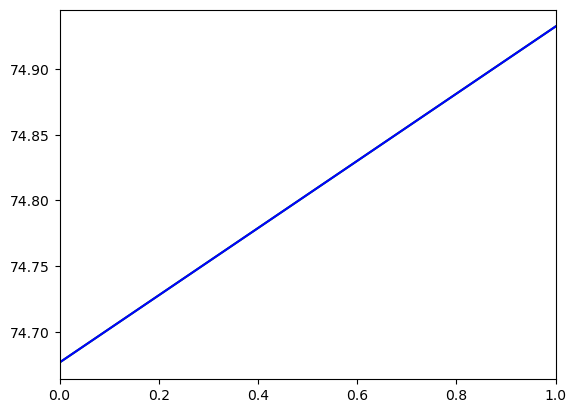

0.25
1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]])]
3
value_matxs: [array([[7.18125, 7.44375],
       [7.18125, 7.44375]]), array([[7.18125, 7.44375],
       [7.18125, 7.44375]]), array([[7.18125, 7.44375],
       [7.18125, 7.44375]]), array([[7.18125, 7.44375],
       [7.18125, 7.44375]])]
4
value_matxs: [array([[10.50921875, 10.88453125],
       [10.50921875, 10.88453125]]), array([[10.50921875, 10.88453125],
       [10.50921875, 10.88453125]]), array([[10.50921875, 10.88453125],
       [10.50921875, 10.88453125]]), array([[10.50921875, 10.88453125],
       [10.50921875, 10.88453125]])]
5
value_matxs: [array([[13.75116797, 14.07289453],
       [13.75116797, 14.07289453]]), array([[13.75116797, 14.07289453],
       [13.75116797, 14.07289453]]), array([[13.75116797, 14.07289453],
       [13.75116797, 14.0728

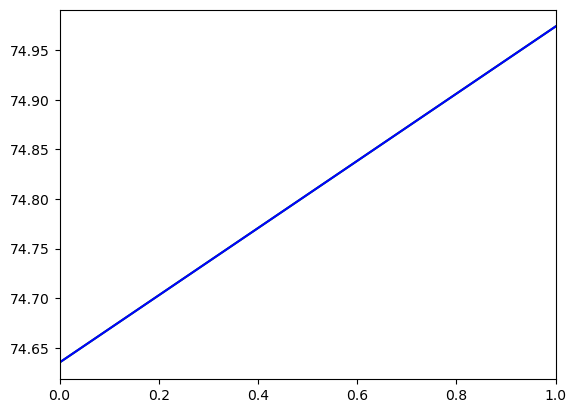

0.5
1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]])]
3
value_matxs: [array([[7.0625, 7.5625],
       [7.0625, 7.5625]]), array([[7.0625, 7.5625],
       [7.0625, 7.5625]]), array([[7.0625, 7.5625],
       [7.0625, 7.5625]]), array([[7.0625, 7.5625],
       [7.0625, 7.5625]])]
4
value_matxs: [array([[10.446875, 10.946875],
       [10.446875, 10.946875]]), array([[10.446875, 10.946875],
       [10.446875, 10.946875]]), array([[10.446875, 10.946875],
       [10.446875, 10.946875]]), array([[10.446875, 10.946875],
       [10.446875, 10.946875]])]
5
value_matxs: [array([[13.66203125, 14.16203125],
       [13.66203125, 14.16203125]]), array([[13.66203125, 14.16203125],
       [13.66203125, 14.16203125]]), array([[13.66203125, 14.16203125],
       [13.66203125, 14.16203125]]), array([[13.66203125, 14.16203125],
     

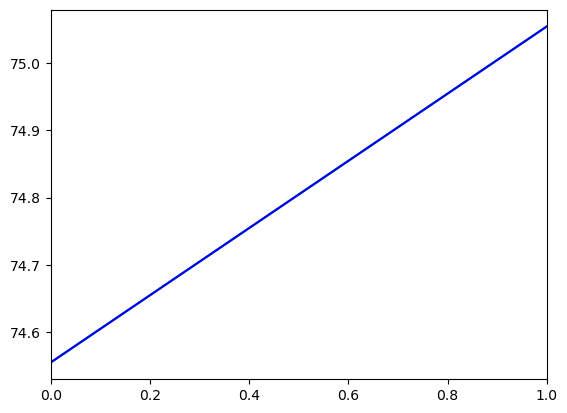

0.75
1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]])]
3
value_matxs: [array([[6.94375, 7.68125],
       [6.94375, 7.68125]]), array([[6.94375, 7.68125],
       [6.94375, 7.68125]]), array([[6.94375, 7.68125],
       [6.94375, 7.68125]]), array([[6.94375, 7.68125],
       [6.94375, 7.68125]])]
4
value_matxs: [array([[10.27171875, 11.12203125],
       [10.27171875, 11.12203125]]), array([[10.27171875, 11.12203125],
       [10.27171875, 11.12203125]]), array([[10.27171875, 11.12203125],
       [10.27171875, 11.12203125]]), array([[10.27171875, 11.12203125],
       [10.27171875, 11.12203125]])]
5
value_matxs: [array([[13.46008203, 14.36398047],
       [13.46008203, 14.36398047]]), array([[13.46008203, 14.36398047],
       [13.46008203, 14.36398047]]), array([[13.46008203, 14.36398047],
       [13.46008203, 14.3639

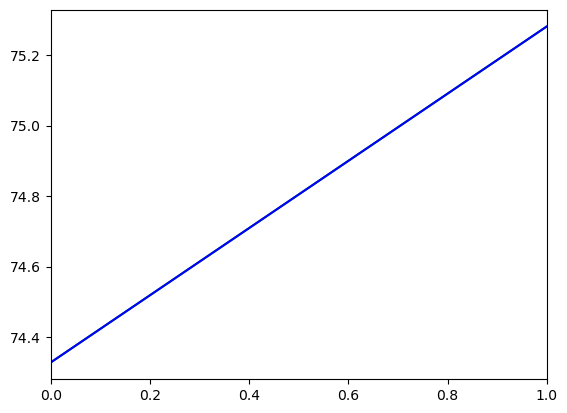

1.0
1
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
value_matxs: [array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]]), array([[3.5, 4. ],
       [3.5, 4. ]])]
3
value_matxs: [array([[6.825, 7.8  ],
       [6.825, 7.8  ]]), array([[6.825, 7.8  ],
       [6.825, 7.8  ]]), array([[6.825, 7.8  ],
       [6.825, 7.8  ]]), array([[6.825, 7.8  ],
       [6.825, 7.8  ]])]
4
value_matxs: [array([[ 9.98375, 11.41   ],
       [ 9.98375, 11.41   ]]), array([[ 9.98375, 11.41   ],
       [ 9.98375, 11.41   ]]), array([[ 9.98375, 11.41   ],
       [ 9.98375, 11.41   ]]), array([[ 9.98375, 11.41   ],
       [ 9.98375, 11.41   ]])]
5
value_matxs: [array([[12.9845625, 14.8395   ],
       [12.9845625, 14.8395   ]]), array([[12.9845625, 14.8395   ],
       [12.9845625, 14.8395   ]]), array([[12.9845625, 14.8395   ],
       [12.9845625, 14.8395   ]]), array([[12.9845625, 14.8395   ],
       [12.9845625, 14.8395   ]])]
6
value_matxs: [

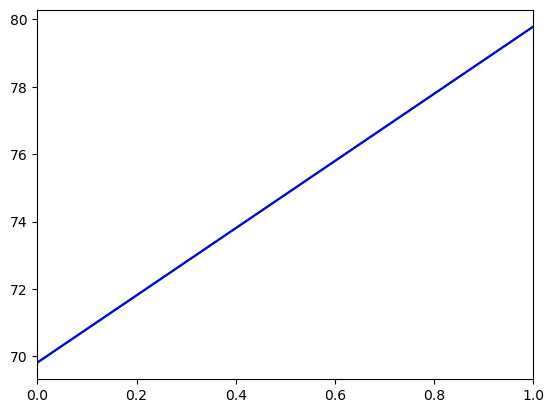

[defaultdict(<class 'list'>, {'0': [array([74.67669524, 74.93243734])], '1': [array([74.67669524, 74.93243734])]}), defaultdict(<class 'list'>, {'0': [array([74.63507476, 74.97405782])], '1': [array([74.63507476, 74.97405782])]}), defaultdict(<class 'list'>, {'0': [array([74.55456629, 75.05456629])], '1': [array([74.55456629, 75.05456629])]}), defaultdict(<class 'list'>, {'0': [array([74.32837581, 75.28075677])], '1': [array([74.32837581, 75.28075677])]}), defaultdict(<class 'list'>, {'0': [array([69.8175952 , 79.79153738])], '1': [array([69.8175952 , 79.79153738])]})]


In [114]:
import random
from collections import defaultdict
import numpy as np

# The rest of the classes and functions are the same as given in the previous code.

# Define the range of p_stay values you want to test
start_p_stay = 0.0
end_p_stay = 1.0
num_steps_p_stay = 5  # Choose the number of steps between start_p_stay and end_p_stay

p_stay_values = np.linspace(start_p_stay, end_p_stay, num_steps_p_stay)

# Define the transition probability P(s'|s,a) for each p_stay value
t_prob_values = [[[[p_stay, 1 - p_stay], [1 - p_stay, p_stay]], [[p_stay, 1 - p_stay], [1 - p_stay, p_stay]]] for p_stay in p_stay_values]

# Create a list to store the results for each p_stay value
results = []

# Loop through each p_stay value and create a new POMDP with the updated transition probability
for p_stay, t_prob in zip(p_stay_values, t_prob_values):
    print(p_stay)
    e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
    rewards = [[3.5, 4.0], [3.5, 4.0]]
    gamma = 0.95
    actions = ('0', '1')  # stay and switch
    states = ('0', '1')
    pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
    utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
    print(utility)
    if utility == None:
        break
    else: 
        plot_pomdp_utility(utility)
    results.append(utility)

# Print or use the results as needed
print(results)


### Subconclusion:

The higher p_stay, the lower the value for left, and the higher for right? (given that rewards stay the same)

### Changes to rewards 

prototype:

In [ ]:
import random
from collections import defaultdict
import numpy as np
import json

# The rest of the classes and functions are the same as given in the previous code.

# Define the range of reward values you want to test
start_reward = 0.0
end_reward = 10
num_steps_reward = 20  # Choose the number of steps between start_reward and end_reward

reward_values = np.linspace(start_reward, end_reward, num_steps_reward)

# Create a list to store the results for each reward value
results = []

# Loop through each reward value and create a new POMDP with the updated reward function
for reward in reward_values:
    print(reward)
    t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
    e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
    gamma = 0.95
    actions = ('0', '1')  # stay and switch
    states = ('0', '1')
    rewards = [[reward, 4.0], [3.5, 4.0]]  # Update the reward values

    pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
    utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
    print(utility)
    if utility is None:
        break
    else: 
        utility_lists = defaultdict(list)
        for action in utility:
                for val in utility[action]:
                    utility_lists[action].append(val.tolist())
                    results.append({
                        'rewards': rewards,
                        't_prob': t_prob,
                        'e_prob': e_prob,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                    })

                    print(results)
                    plot_pomdp_utility(utility)
                    results.append(utility)

print(results)
with open('reward_proto_results.json', 'w') as json_file:
    json.dump(results, json_file)


### Subconclusion: 
Big shift between 3 and 4 --> the curve changes sides; this makes sense because the counterbalance is 4

- now I need to adjust the code such that it iterates through different combinations of rewards.

Experiment of changing rewards

In [ ]:
import random
from collections import defaultdict
import numpy as np
import json

# The rest of the classes and functions are the same as given in the previous code.

# Define the range of reward values you want to test
start_reward = 0.0
end_reward = 10
num_steps_reward = 10  # Choose the number of steps between start_reward and end_reward

reward_values = np.linspace(start_reward, end_reward, num_steps_reward)

# Create a list to store the results for each combination of reward values
results = []

# Loop through each reward value for the first reward
for reward1 in reward_values:
    # Loop through each reward value for the second reward
    for reward2 in reward_values:
        # Loop through each reward value for the third reward
        for reward3 in reward_values:
            # Loop through each reward value for the fourth reward
            for reward4 in reward_values:
                print(reward1, reward2, reward3, reward4)
                p_stay = 0.65
                t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
                e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
                gamma = 0.95
                actions = ('0', '1')  # stay and switch
                states = ('0', '1')  # Assuming there are two states
                print(f'Rewards:{rewards}')
                print(f'Probaility of staying:{p_stay}')
                print(f'Transition Probabilities:{t_prob}')
                print(f'Gamma:{gamma}')
                print(f'Epsilon:{epsilon}')

                # Update the reward values for both states
                rewards = [[reward1, reward2], [reward3, reward4]]

                pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
                utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
                print(utility)
                if utility is None:
                    break
                if len(utility)<2: #this is because we are interested in finding a combo that actually intersects
                    break
                else: 
                    
                    # Save the results into a dictionary
                    # result_dict = {
                    #     'Utility': utility.to_list(),
                    #     'e_prob': e_prob,
                    #     'gamma': gamma,
                    #     'rewards': rewards,
                    #     't_prob': t_prob,
                    #     'epsilon': epsilon
                    # }
                           # Convert numpy.ndarray objects to lists in the utility
                    utility_lists = defaultdict(list)
                    for action in utility:
                        for val in utility[action]:
                            utility_lists[action].append(val.tolist())

                    results.append({
                        'rewards': rewards,
                        't_prob': t_prob,
                        'e_prob': e_prob,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                    })

                    print(results)
                    plot_pomdp_utility(utility)
                # results.append(utility)

# # Print or use the results as needed
# print(results)
with open('rewards_results.json', 'w') as json_file:
    json.dump(results, json_file)


In [95]:
print(f'Rewards:{rewards}')
print(f'Probaility of staying:{p_stay}')
print(f'Transition Probabilities:{t_prob}')
print(f'Gamma:{gamma}')
print(f'Epsilon:{epsilon}')

Rewards:[[0.0, 1.6666666666666667], [1.6666666666666667, 0.0]]
Probaility of staying:0.89
Transition Probabilities:[[[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]], [[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]]]
Gamma:0.95
Epsilon:0.4


Rewards:[[0.0, 1.6666666666666667], [1.6666666666666667, 0.0]]
Transition Probabilities:[[[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]], [[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]]]
Gamma:0.95
Epsilon:0.4

Still seems like I need a better stopping system

--> also for the intersected curves it would be good to also eventually add that they should not be the same!

- also need to find a way to safe all the useful combinations 

### Changes to e_prob

1. First experiment for e_prob changes; parameters:

- Rewards:[[0.0, 1.6666666666666667], [1.6666666666666667, 0.0]]
- Probaility of staying:0.89
- Transition Probabilities:[[[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]], [[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]]]
- Gamma:0.95
- Epsilon:0.4


In [ ]:
# e_prob = [[[e_proba, 1-e_proba], [1-e_proba, e_proba]], [[e_proba, 1-e_proba], [1-e_proba, e_proba]]]

import random
from collections import defaultdict
import numpy as np
import json

# The rest of the classes and functions are the same as given in the previous code.

# Define the range of e_proba values you want to test
start_e_proba = 0.0
end_e_proba = 1.0
num_steps_e_proba = 5  # Choose the number of steps between start_e_proba and end_e_proba

e_proba_values = np.linspace(start_e_proba, end_e_proba, num_steps_e_proba)

# Create a list to store the results for each combination of e_proba values and reward values
results = []

# Loop through each e_proba value for the first evidence probability
for e_proba1 in e_proba_values:
    # Loop through each e_proba value for the second evidence probability
    for e_proba2 in e_proba_values:
        print(e_proba1, e_proba2)
        t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
        # Update the evidence probabilities for both states and both actions
        e_prob = [[[e_proba1, 1 - e_proba1], [1 - e_proba1, e_proba1]], [[e_proba2, 1 - e_proba2], [1 - e_proba2, e_proba2]]]
        print(f'e_prob:{e_prob}')
        gamma = 0.95
        actions = ('0', '1')  # stay and switch
        states = ('0', '1')  # Assuming there are two states
        rewards = [[reward1, reward2], [reward3, reward4]]
        print(f'Rewards:{rewards}')
        print(f'Probaility of staying:{p_stay}')
        print(f'Transition Probabilities:{t_prob}')
        print(f'Gamma:{gamma}')
        print(f'Epsilon:{epsilon}')
        print(f'e_proba_1:{e_proba1}')
        print(f'e_proba_2:{e_proba2}')

        pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
        utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
        print(utility)
        print(f'Utility is:{utility}')
        if utility is None:
            break
        else: 
            utility_lists = defaultdict(list)
            for action in utility:
                for val in utility[action]:
                    utility_lists[action].append(val.tolist())
                    results.append({
                        'rewards': rewards,
                        't_prob': t_prob,
                        'e_prob': e_prob,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                    })

                    print(results)
                    plot_pomdp_utility(utility)
                    results.append(utility)

print(results)
with open('e_prob_results.json', 'w') as json_file:
    json.dump(results, json_file)


# Define the range of reward values you want to test
start_reward = 0.0
end_reward = 10
num_steps_reward = 10  # Choose the number of steps between start_reward and end_reward

reward_values = np.linspace(start_reward, end_reward, num_steps_reward)

# Create a list to store the results for each combination of reward values
results = []

# Loop through each reward value for the first reward
for reward1 in reward_values:
    # Loop through each reward value for the second reward
    for reward2 in reward_values:
        # Loop through each reward value for the third reward
        for reward3 in reward_values:
            # Loop through each reward value for the fourth reward
            for reward4 in reward_values:
                print(reward1, reward2, reward3, reward4)
                p_stay = 0.65
                t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
                e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
                gamma = 0.95
                actions = ('0', '1')  # stay and switch
                states = ('0', '1')  # Assuming there are two states
                print(f'Rewards:{rewards}')
                print(f'Probaility of staying:{p_stay}')
                print(f'Transition Probabilities:{t_prob}')
                print(f'Gamma:{gamma}')
                print(f'Epsilon:{epsilon}')

                # Update the reward values for both states
                rewards = [[reward1, reward2], [reward3, reward4]]

                pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
                utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)
                print(utility)
                if utility is None:
                    break
                if len(utility)<2: #this is because we are interested in finding a combo that actually intersects
                    break
                else: 
                    
                    # Save the results into a dictionary
                    # result_dict = {
                    #     'Utility': utility.to_list(),
                    #     'e_prob': e_prob,
                    #     'gamma': gamma,
                    #     'rewards': rewards,
                    #     't_prob': t_prob,
                    #     'epsilon': epsilon
                    # }
                           # Convert numpy.ndarray objects to lists in the utility
                    utility_lists = defaultdict(list)
                    for action in utility:
                        for val in utility[action]:
                            utility_lists[action].append(val.tolist())

                    results.append({
                        'rewards': rewards,
                        't_prob': t_prob,
                        'e_prob': e_prob,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                    })

                    print(results)
                    plot_pomdp_utility(utility)
                # results.append(utility)

# # Print or use the results as needed
# print(results)
with open('rewards_results.json', 'w') as json_file:
    json.dump(results, json_file)

Looking good already! but now need to figure out the configurations!
- also need to know when green and when blue, but I guess that just depends on its directions!

Play around with rewards on wednesday!!

- safe the right combinations in a dictionary!!
- also try to safe the images accordingly
- also change the way the images look! they need more descriptions! --> legend, and x axis and y axis description

Could there be a way to make this code/simulation more efficient? discuss with Andrew!

## Changing parameters at the same time in a bigger loop

- There does not seem to be much difference in epsilon, or gamma changes. The only differences there would be the value as such. So these parameters are not important for finding the right parameters. 
- They will be interesting again once we have an interesting set of parameters
- I think neither for p_stay

### Changing rewards and e_prob 

- because they seem to have the biggest impact

In [ ]:
import random
from collections import defaultdict
import numpy as np
import json

# Rest of the classes and functions are the same as given in the previous code.

# Define the range of reward values you want to test
start_reward = 0.0
end_reward = 5
num_steps_reward = 4  # Choose the number of steps between start_reward and end_reward

reward_values = np.linspace(start_reward, end_reward, num_steps_reward)

# Define the range of e_proba values you want to test
start_e_proba = 0.0
end_e_proba = 1.0
num_steps_e_proba = 1  # Choose the number of steps between start_e_proba and end_e_proba

e_proba_values = np.linspace(start_e_proba, end_e_proba, num_steps_e_proba)

# Create a list to store the results for each combination of reward values and e_proba values
results = []

# Loop through each reward value for the first reward
for reward1 in reward_values:
    # Loop through each reward value for the second reward
    for reward2 in reward_values:
        # Loop through each reward value for the third reward
        for reward3 in reward_values:
            # Loop through each reward value for the fourth reward
            for reward4 in reward_values:
                # Loop through each e_proba value for the first evidence probability
                for e_proba1 in e_proba_values:
                    # Loop through each e_proba value for the second evidence probability
                    for e_proba2 in e_proba_values:
                        print(reward1, reward2, reward3, reward4, e_proba1, e_proba2)

                        p_stay = 0.89
                        t_prob = [[[p_stay, 1-p_stay], [1-p_stay,p_stay]], [[p_stay, 1-p_stay], [1-p_stay,p_stay]]]
                        # Update the evidence probabilities for both states and both actions
                        e_prob = [[[e_proba1, 1 - e_proba1], [1 - e_proba1, e_proba1]], [[e_proba2, 1 - e_proba2], [1 - e_proba2, e_proba2]]]

                        gamma = 0.95
                        actions = ('0', '1')  # stay and switch
                        states = ('0', '1')  # Assuming there are two states

                        # Update the reward values for both states
                        rewards = [[reward1, reward2], [reward3, reward4]]

                        pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
                        utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.4)

                        if utility is not None and len(utility) >= 2:  # Check if valid utility
                            # Convert numpy.ndarray objects to lists in the utility
                            utility_lists = defaultdict(list)
                            for action in utility:
                                for val in utility[action]:
                                    utility_lists[action].append(val.tolist())

                            results.append({
                                'rewards': rewards,
                                't_prob': t_prob,
                                'e_prob': e_prob,
                                'gamma': gamma,
                                'epsilon': epsilon,
                                'utility': dict(utility_lists)  # Convert the defaultdict back to a regular dictionary
                            })

                            print(results)
                            plot_pomdp_utility(utility)

# Print or use the results as needed
print(results)

# Save the results to a text file in JSON format
with open('combined_results.json', 'w') as json_file:
    json.dump(results, json_file)


I am still having difficulties with saving the right combinations. 

In [ ]:
e_prob = [[[0.75, 0.25], [0.25, 0.75]], [[0.25, 0.75], [0.75, 0.25]]]
Rewards = [[0.0, 1.6666666666666667], [1.6666666666666667, 0.0]]
p_stay = 0.89
t_prob = [[[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]], [[0.89, 0.10999999999999999], [0.10999999999999999, 0.89]]]
Gamma = 0.95
Epsilon = 0.4


## Belief Updating using Value Iteration Method (online solving)

- might be hard but doable
- find a way to compare with utility numbers so that at each iteration we know whats up
- then it would be important to save whether left or right was chosen so we can put this into a diagram


Could belief updating just be changing e_prob? --> iterating from a more random distribution

### Capturing the Optimal Policy

### Belief updating function

### Switching function (also visualize with ones and zeros)

### Simulation (with everything else fixed except for e_prob)

### If time --> Changing reward